In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
art_data = pd.read_csv("Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [3]:
#since data already ranges from -0.15 to 0.15, omit minmaxscale
# Define lookback period and split inputs/labels


def split_data(stock, lookback):
    data_raw = stock# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30 # choose sequence length
train_x,train_y,test_x,test_y = split_data(art_data.values, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5822, 30, 1)
y_train.shape:  (5822, 1)
X_test.shape:  (1455, 30, 1)
y_test.shape:  (1455, 1)


In [4]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True,batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [6]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.1):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(out[:,-1])
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    mseloss = []
    l1loss = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss1 = 0.
        avg_loss2 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            h = h.data
            model.zero_grad()

            out, h = model.forward(x.float(), h)
            loss1 = criterion1(out, label.float())
            loss1.backward()
            loss2 = criterion2(out, label.float())
           
            optimizer.step()
            avg_loss1 += loss1.item()
            avg_loss2 += loss2.item()
        
        avg_loss1 /= length
        avg_loss2 /= length
        print("Epoch {}/{} Done, Total MSELoss: {}".format(epoch, EPOCHS, avg_loss1))
        print("Epoch {}/{} Done, Total L1Loss: {}".format(epoch, EPOCHS, avg_loss2))
        
        mseloss.append(avg_loss1)
        l1loss.append(avg_loss2)
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, mseloss, l1loss

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        criterion2 = nn.L1Loss()
        
        loss1 = 0
        loss2 = 0
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
    
            out, h = model.forward(x.float(), h)
            loss1 = criterion1(out, label.float()).item()
            loss2 = criterion2(out, label.float()).item()
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        print("Total MSELoss: {}".format(loss1))
        print("Total L1Loss: {}".format(loss2))
        
            
    return predictions, values, loss1,loss2

In [7]:
lr = 0.001
gru_model1, mseloss, l1loss = train(train_loader, lr, model_type="GRU")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of GRU model
Epoch 1/20 Done, Total MSELoss: 0.0012579522052369107
Epoch 1/20 Done, Total L1Loss: 0.02394580585985548
Total Time Elapsed: 1.7116855440000336 seconds

Epoch 2/20 Done, Total MSELoss: 3.835558677059857e-05
Epoch 2/20 Done, Total L1Loss: 0.004944115036374165
Total Time Elapsed: 1.9224315789999764 seconds

Epoch 3/20 Done, Total MSELoss: 3.3809780992063075e-05
Epoch 3/20 Done, Total L1Loss: 0.004660195285557873
Total Time Elapsed: 1.7030136149999748 seconds

Epoch 4/20 Done, Total MSELoss: 3.0773544575721545e-05
Epoch 4/20 Done, Total L1Loss: 0.004450290515604947
Total Time Elapsed: 1.6854826850000109 seconds

Epoch 5/20 Done, Total MSELoss: 2.9959451138792145e-05
Epoch 5/20 Done, Total L1Loss: 0.004377090773131285
Total Time Elapsed: 1.935965275000001 seconds

Epoch 6/20 Done, Total MSELoss: 2.8655805322664995e-05
Epoch 6/20 Done, Total L1Loss: 0.004293904068051941
Total Time Elapsed: 2.123649193999995 seconds

Epoch 7/20 Done, Total MSELoss: 2.8039783582

In [8]:
predictions, values, loss1,loss2 = evaluate(gru_model1,test_loader)

Total MSELoss: 5.5909546063048765e-05
Total L1Loss: 0.007477268576622009


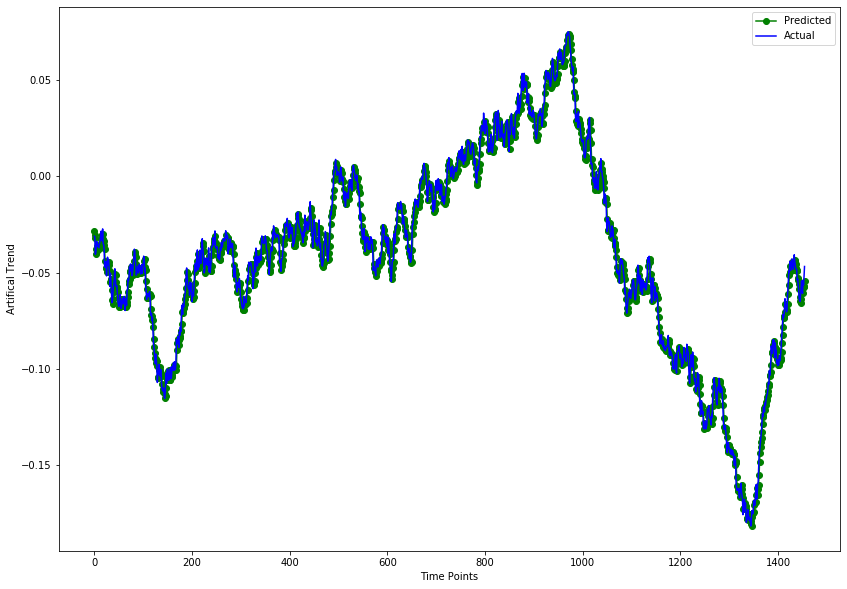

In [9]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artifical Trend')
plt.xlabel('Time Points')
plt.legend()

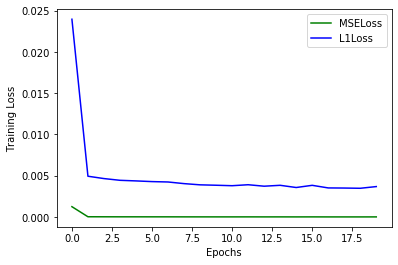

In [10]:
plt.plot(mseloss, color="g", label="MSELoss")
plt.plot(l1loss, color="b", label="L1Loss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

## Microsoft Stock

In [11]:
microsoft_df = pd.read_csv("Microsoft_Stock.csv")
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [12]:
# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
scaled_micro = sc.fit_transform(microsoft_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_micro, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1185, 30, 1)
y_train.shape:  (1185, 1)
X_test.shape:  (296, 30, 1)
y_test.shape:  (296, 1)


In [13]:
batch_size = 23
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [16]:
lr = 0.001
gru_model2, mseloss, l1loss = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1/20 Done, Total MSELoss: 0.026298126571026502
Epoch 1/20 Done, Total L1Loss: 0.1312868893146515
Total Time Elapsed: 0.7641513989999567 seconds

Epoch 2/20 Done, Total MSELoss: 0.004125736212682016
Epoch 2/20 Done, Total L1Loss: 0.0447430972229032
Total Time Elapsed: 0.6053325110000287 seconds

Epoch 3/20 Done, Total MSELoss: 0.00013823491548571517
Epoch 3/20 Done, Total L1Loss: 0.009136302140997905
Total Time Elapsed: 0.6056292690000191 seconds

Epoch 4/20 Done, Total MSELoss: 8.941777253080635e-05
Epoch 4/20 Done, Total L1Loss: 0.0071010483364921575
Total Time Elapsed: 0.5973976650000168 seconds

Epoch 5/20 Done, Total MSELoss: 7.7614008677854e-05
Epoch 5/20 Done, Total L1Loss: 0.006475814453819219
Total Time Elapsed: 0.6169956759999877 seconds

Epoch 6/20 Done, Total MSELoss: 7.687713011417894e-05
Epoch 6/20 Done, Total L1Loss: 0.006524542195941596
Total Time Elapsed: 0.5954845589999422 seconds

Epoch 7/20 Done, Total MSELoss: 7.034394441100577e-

Total MSELoss: 0.000903818232472986
Total L1Loss: 0.03006356954574585


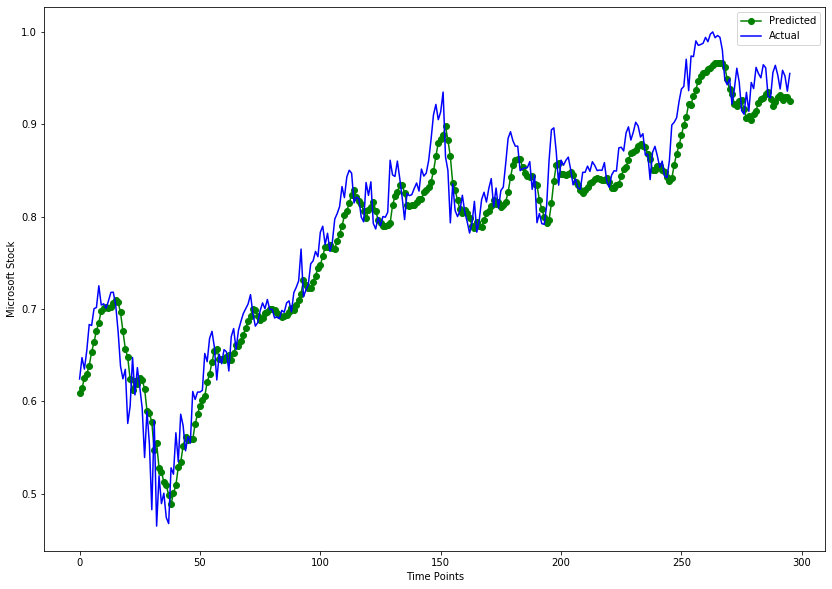

In [17]:
predictions, values,loss1,loss2 = evaluate(gru_model2,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock')
plt.xlabel('Time Points')
plt.legend()

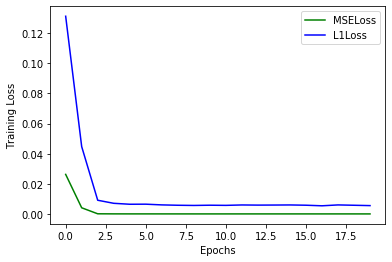

In [18]:
plt.plot(mseloss, color="g", label="MSELoss")
plt.plot(l1loss, color="b", label="L1Loss")
#plt.plot(nllloss, color="r", label="NLLLoss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

## Crude Oil 

In [19]:
oil_df = pd.read_csv("oil.csv")
oil_df['DATE'] = pd.to_datetime(oil_df['DATE'])
oil_df.set_index('DATE',inplace=True)
for index, oil in enumerate(oil_df["DCOILBRENTEU"]):
    if oil == ".":
        oil_df["DCOILBRENTEU"][index] = None
oil_df.dropna(inplace=True)
oil_df

,DCOILBRENTEU
DATE,
2015-11-02,47.91
2015-11-03,48.00
2015-11-04,46.96
2015-11-05,47.19
2015-11-06,46.09
...,...
2021-10-26,85.11
2021-10-27,84.12
2021-10-28,83.4


In [20]:
# Scaling the input data
sc = MinMaxScaler()
#label_sc = MinMaxScaler()
scaled_oil = sc.fit_transform(oil_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_oil, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1199, 30, 1)
y_train.shape:  (1199, 1)
X_test.shape:  (300, 30, 1)
y_test.shape:  (300, 1)


In [21]:
batch_size = 23
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [22]:
lr = 0.001
gru_model3, mseloss, l1loss = train(train_loader, lr, model_type="GRU")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of GRU model
Epoch 1/20 Done, Total MSELoss: 0.0523274983995809
Epoch 1/20 Done, Total L1Loss: 0.17218145728111267
Total Time Elapsed: 0.6746116580000034 seconds

Epoch 2/20 Done, Total MSELoss: 0.009915443325343613
Epoch 2/20 Done, Total L1Loss: 0.07867142644066077
Total Time Elapsed: 0.684158337000099 seconds

Epoch 3/20 Done, Total MSELoss: 0.0012664002542106363
Epoch 3/20 Done, Total L1Loss: 0.025697931432380125
Total Time Elapsed: 0.6857052370000929 seconds

Epoch 4/20 Done, Total MSELoss: 0.0007895153567705376
Epoch 4/20 Done, Total L1Loss: 0.020831757995228354
Total Time Elapsed: 0.6972282540000379 seconds

Epoch 5/20 Done, Total MSELoss: 0.0007423474139963778
Epoch 5/20 Done, Total L1Loss: 0.02001173570393943
Total Time Elapsed: 0.6909507959999246 seconds

Epoch 6/20 Done, Total MSELoss: 0.0006623185724422981
Epoch 6/20 Done, Total L1Loss: 0.018894112704751585
Total Time Elapsed: 0.8627563319998899 seconds

Epoch 7/20 Done, Total MSELoss: 0.0006299636583067835

Total MSELoss: 0.0005255619762465358
Total L1Loss: 0.022925138473510742


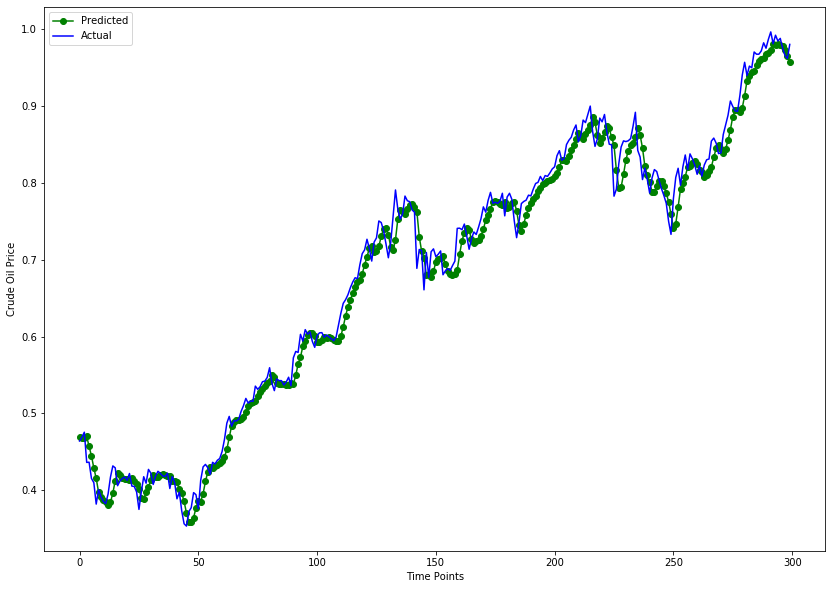

In [23]:
predictions, values,loss1,loss2  = evaluate(gru_model3,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.xlabel('Time Points')
plt.legend()

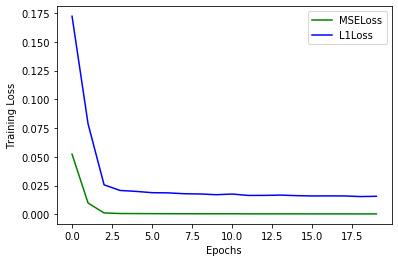

In [24]:
plt.plot(mseloss, color="g", label="MSELoss")
plt.plot(l1loss, color="b", label="L1Loss")
#plt.plot(nllloss, color="r", label="NLLLoss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

# Bitcoin

In [25]:
coin_df = pd.read_csv("coin.csv")
coin_df['Date'] = pd.to_datetime(coin_df['Date'])
coin_df.set_index('Date',inplace=True)
coin_df = pd.DataFrame(coin_df['Close'])
coin_df.dropna(inplace=True)
coin_df

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000
...,...
2021-07-02 23:59:59,33897.048590
2021-07-03 23:59:59,34668.548402
2021-07-04 23:59:59,35287.779766


In [26]:
# Scaling the input data
sc = MinMaxScaler()
#label_sc = MinMaxScaler()
scaled_coin = sc.fit_transform(coin_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_coin, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (2369, 30, 1)
y_train.shape:  (2369, 1)
X_test.shape:  (592, 30, 1)
y_test.shape:  (592, 1)


In [27]:
batch_size = 47
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [28]:
lr = 0.001
gru_model4, mseloss, l1loss= train(train_loader, lr, hidden_dim = 50, model_type="GRU")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of GRU model
Epoch 1/20 Done, Total MSELoss: 0.0020893901342060417
Epoch 1/20 Done, Total L1Loss: 0.03696405723690987
Total Time Elapsed: 0.8786454859998685 seconds

Epoch 2/20 Done, Total MSELoss: 0.00013969430026918416
Epoch 2/20 Done, Total L1Loss: 0.007693580589257181
Total Time Elapsed: 0.8366675950001081 seconds

Epoch 3/20 Done, Total MSELoss: 4.2349441628175555e-05
Epoch 3/20 Done, Total L1Loss: 0.003332425246480852
Total Time Elapsed: 0.7705448159999833 seconds

Epoch 4/20 Done, Total MSELoss: 4.1034401210708896e-05
Epoch 4/20 Done, Total L1Loss: 0.0035038399626500906
Total Time Elapsed: 0.8184364480000568 seconds

Epoch 5/20 Done, Total MSELoss: 3.666903798148269e-05
Epoch 5/20 Done, Total L1Loss: 0.003216663198545575
Total Time Elapsed: 0.9031989009999961 seconds

Epoch 6/20 Done, Total MSELoss: 3.535319082402566e-05
Epoch 6/20 Done, Total L1Loss: 0.003078726383391768
Total Time Elapsed: 0.9290116360000411 seconds

Epoch 7/20 Done, Total MSELoss: 3.35521084

Total MSELoss: 0.00010566518903942779
Total L1Loss: 0.010279357433319092


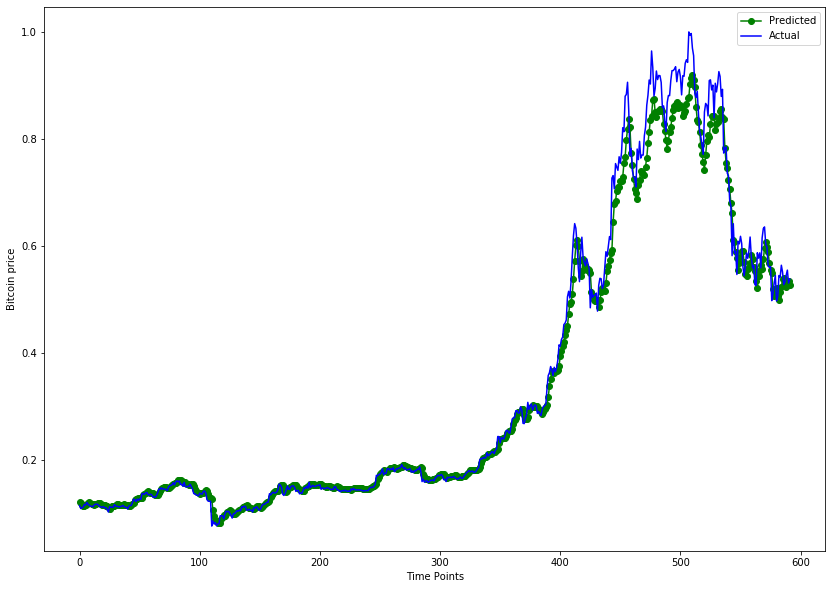

In [29]:
predictions, values,loss1,loss2= evaluate(gru_model4,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin price')
plt.xlabel('Time Points')
plt.legend()

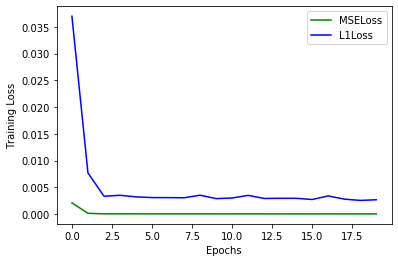

In [30]:
plt.plot(mseloss, color="g", label="MSELoss")
plt.plot(l1loss, color="b", label="L1Loss")
#plt.plot(nllloss, color="r", label="NLLLoss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

# S&P500

In [31]:
sp500_df = pd.read_csv("sp500.csv")
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df.set_index('Date',inplace=True)
sp500_df = pd.DataFrame(sp500_df['SP500'])
sp500_df.dropna(inplace=True)
sp500_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [32]:
# Scaling the input data
sc = MinMaxScaler()
#label_sc = MinMaxScaler()
scaled_sp = sc.fit_transform(sp500_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1390, 30, 1)
y_train.shape:  (1390, 1)
X_test.shape:  (348, 30, 1)
y_test.shape:  (348, 1)


In [33]:
batch_size = 28
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [34]:
lr = 0.001
gru_model5, mseloss, l1loss = train(train_loader, lr, hidden_dim = 50, model_type="GRU")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of GRU model
Epoch 1/20 Done, Total MSELoss: 0.001132946778908467
Epoch 1/20 Done, Total L1Loss: 0.023748798438404897
Total Time Elapsed: 0.7370409559998734 seconds

Epoch 2/20 Done, Total MSELoss: 0.00032095331089851463
Epoch 2/20 Done, Total L1Loss: 0.013285314550205153
Total Time Elapsed: 0.6654168940001455 seconds

Epoch 3/20 Done, Total MSELoss: 0.0002286920383511995
Epoch 3/20 Done, Total L1Loss: 0.010864908616913825
Total Time Elapsed: 0.649454778000063 seconds

Epoch 4/20 Done, Total MSELoss: 0.0001442964630026539
Epoch 4/20 Done, Total L1Loss: 0.008526068665467354
Total Time Elapsed: 0.6229697390001547 seconds

Epoch 5/20 Done, Total MSELoss: 5.4034311168444606e-05
Epoch 5/20 Done, Total L1Loss: 0.005158792767787771
Total Time Elapsed: 0.6860476560000279 seconds

Epoch 6/20 Done, Total MSELoss: 7.158489352707188e-06
Epoch 6/20 Done, Total L1Loss: 0.0016417971031730805
Total Time Elapsed: 0.6923380880000423 seconds

Epoch 7/20 Done, Total MSELoss: 2.3502949938

Total MSELoss: 0.0036662777420133352
Total L1Loss: 0.060549795627593994


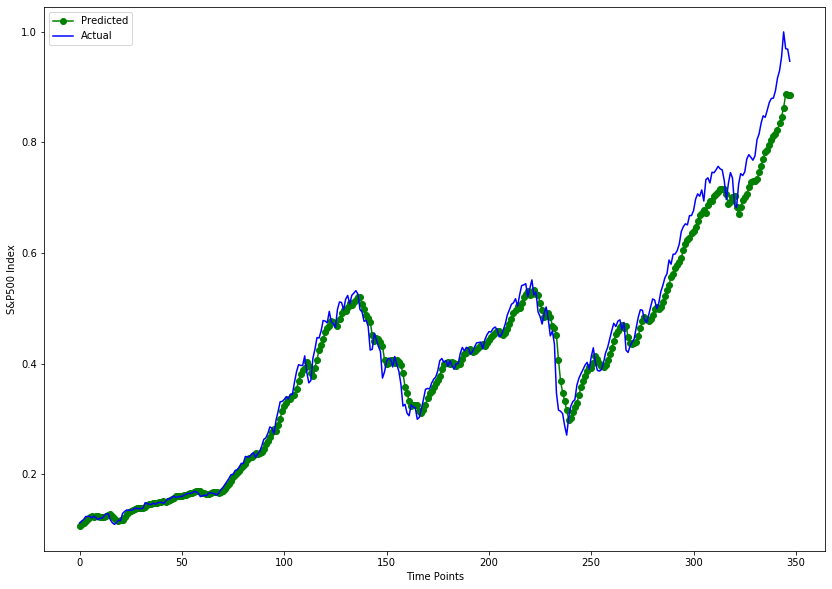

In [35]:
predictions, values,loss1,loss2 = evaluate(gru_model5,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P500 Index')
plt.xlabel('Time Points')
plt.legend()

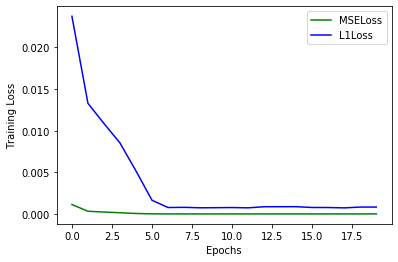

In [36]:
plt.plot(mseloss, color="g", label="MSELoss")
plt.plot(l1loss, color="b", label="L1Loss")
#plt.plot(nllloss, color="r", label="NLLLoss")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()